In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 2.9 MB 12.5 MB/s 
     |████████████████████████████████| 3.3 MB 32.6 MB/s 
     |████████████████████████████████| 636 kB 32.1 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 1.2 MB 11.1 MB/s 


In [2]:
import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *
from plotting_helper import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'

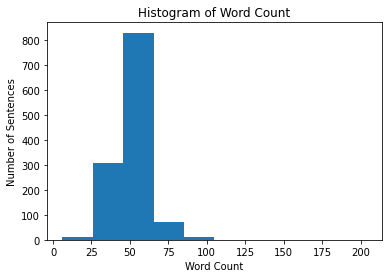

In [4]:
plot_histogram(data['Lyric'])

##### From the histogram, it is evident that most of the sentences have 50 words and some have 75. Although there are sentences with 100 words, the perecentage is very minimal. Hence maximum sequence length is considered as 75.

In [5]:
MAX_SEQ_LEN = 75
gpu, cpu = get_devices()

In [6]:
chk_point = 'ai4bharat/indic-bert'
base_model, tokenizer = load_bert_model(chk_point)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'predictions.dense.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

In [7]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=MAX_SEQ_LEN)

In [8]:
txt_only_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.TXT,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.1, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Text Only Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.691 / Validation : 0.672


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 6.785536 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.649 / Validation : 0.624
Time for epoch : 6.561264 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.602 / Validation : 0.596
Time for epoch : 6.549434 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.561 / Validation : 0.574
Time for epoch : 6.563641 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.530 / Validation : 0.556
Time for epoch : 6.588653 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.510 / Validation : 0.574
Time for epoch : 6.201341 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.454 / Validation : 0.645
Time for epoch : 6.194867 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.430 / Validation : 0.849

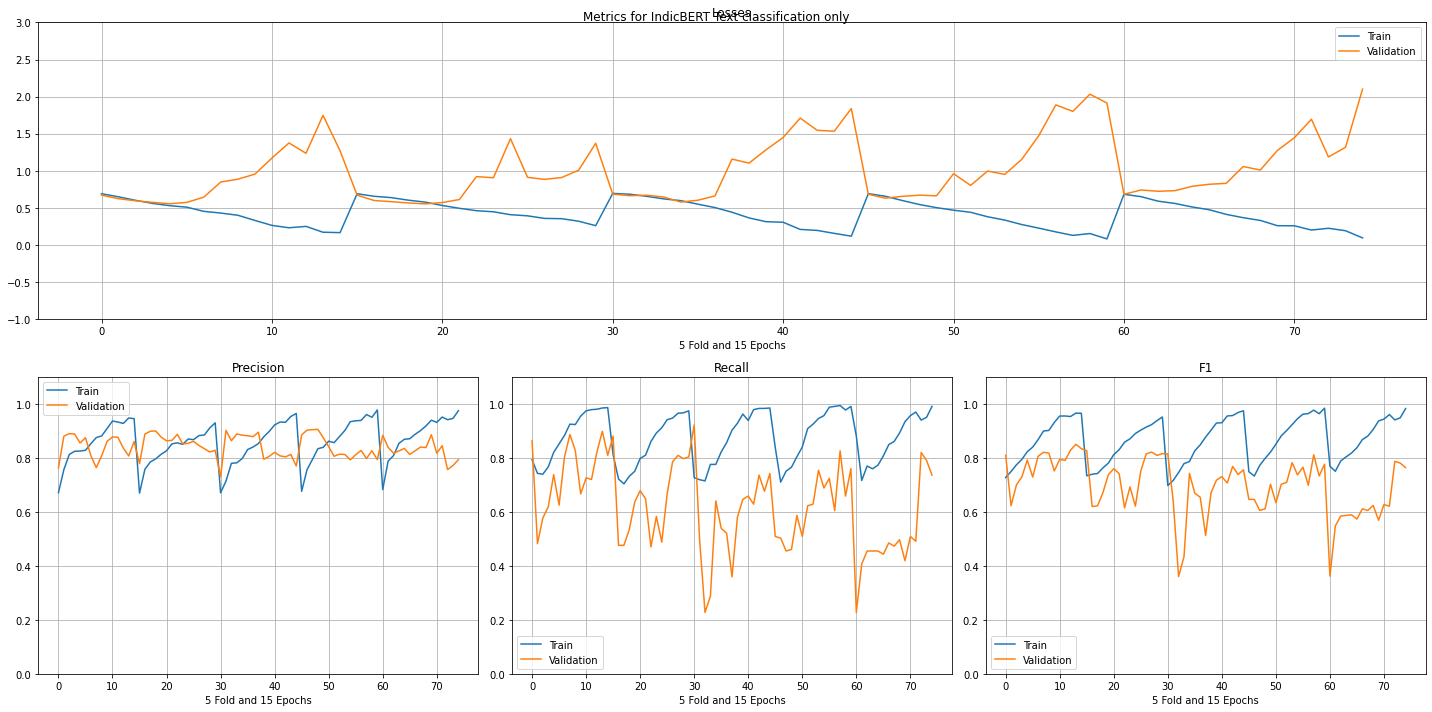

In [9]:
plot_results(txt_only_results[0], 'IndicBERT Text classification only')

In [10]:
txt_only_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
13,0.966276,0.850704,0.948201,0.807487,0.985052,0.898810,0.172171,1.747546
14,0.965618,0.834356,0.945559,0.860759,0.986547,0.809524,0.166797,1.269245
12,0.953488,0.828829,0.927864,0.836364,0.980568,0.821429,0.250894,1.236037
0,0.733784,0.826816,0.669544,0.778947,0.811659,0.880952,0.690882,0.671919
12,0.923517,0.821752,0.884932,0.834356,0.965620,0.809524,0.354809,0.908971
...,...,...,...,...,...,...,...,...
1,0.750586,0.548387,0.788177,0.839506,0.716418,0.407186,0.651544,0.741374
7,0.877447,0.512821,0.853315,0.895522,0.902985,0.359281,0.441340,1.157418
3,0.779026,0.434389,0.781955,0.888889,0.776119,0.287425,0.621218,0.646017
0,0.769231,0.361905,0.682870,0.883721,0.880597,0.227545,0.683640,0.683174


In [11]:
mfcc_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MFCC,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Fusion Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.708 / Validation : 0.679


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 6.749408 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.684 / Validation : 0.658
Time for epoch : 6.761974 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.638 / Validation : 0.643
Time for epoch : 6.806064 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.607 / Validation : 0.643
Time for epoch : 6.346291 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.577 / Validation : 0.612
Time for epoch : 6.767704 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.530 / Validation : 0.598
Time for epoch : 6.740968 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.492 / Validation : 0.716
Time for epoch : 6.34397 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.472 / Validation : 0.585


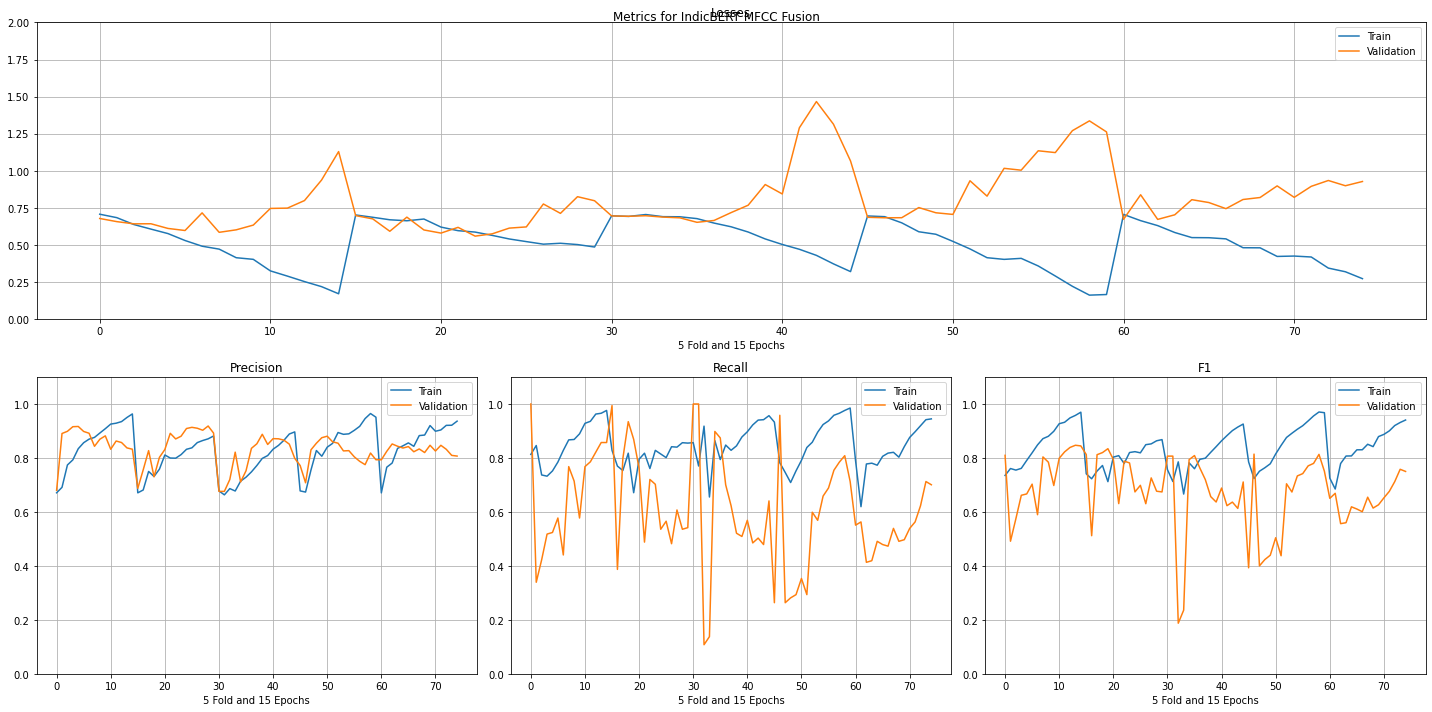

In [12]:
plot_results(mfcc_fusion_results[0], 'IndicBERT MFCC Fusion')

In [13]:
mfcc_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
13,0.957746,0.847059,0.950000,0.837209,0.965620,0.857143,0.219397,0.937555
14,0.969562,0.844575,0.963127,0.832370,0.976084,0.857143,0.171349,1.129467
12,0.948454,0.838906,0.934688,0.857143,0.962631,0.821429,0.253482,0.799432
4,0.712133,0.834286,0.758446,0.802198,0.671151,0.869048,0.675014,0.601349
11,0.932241,0.822430,0.928783,0.862745,0.935725,0.785714,0.290358,0.748513
...,...,...,...,...,...,...,...,...
3,0.763666,0.423423,0.827526,0.854545,0.708955,0.281437,0.589252,0.752242
2,0.750751,0.400000,0.755287,0.830189,0.746269,0.263473,0.649354,0.683893
0,0.785176,0.392857,0.677874,0.771930,0.932836,0.263473,0.695694,0.686669
3,0.666161,0.235897,0.677469,0.821429,0.655224,0.137725,0.691052,0.688029


In [17]:
mel_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MEL,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.1, lr=3e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=1, clip_at=1.0, img_path=IMG_PATH, hidden_dim=64,
                                       img_height=80, img_width=80)

Running Fusion Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  Batch    50  of     62.
Evaluating
Losses - Train : 0.694 / Validation : 0.683


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 31.776867 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.655 / Validation : 0.644
Time for epoch : 31.856846 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.585 / Validation : 0.587
Time for epoch : 31.75862 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.525 / Validation : 0.558
Time for epoch : 31.789284 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.474 / Validation : 0.637
Time for epoch : 31.408487 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.400 / Validation : 0.758
Time for epoch : 31.19008 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.367 / Validation : 0.811
Time for epoch : 31.438661 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.354 / Validation : 

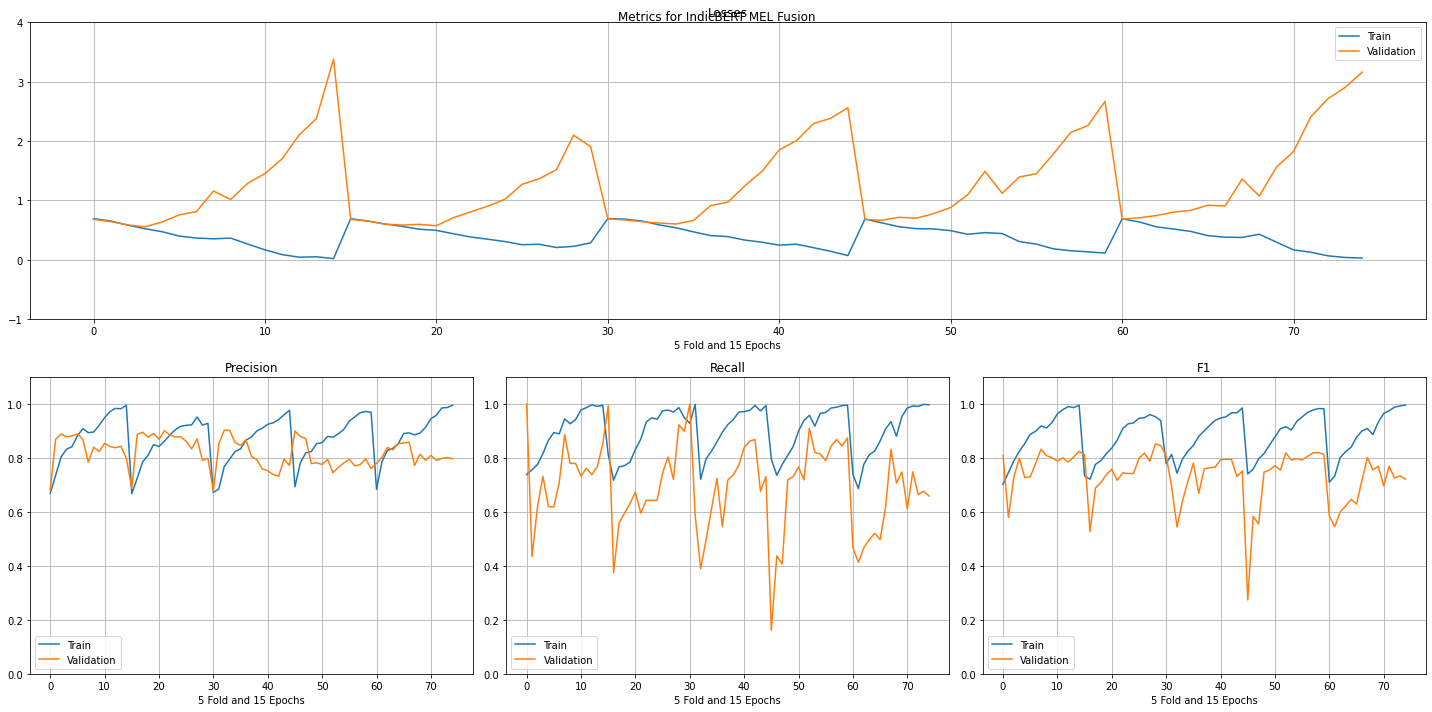

In [18]:
plot_results(mel_fusion_results[0], 'IndicBERT MEL Fusion')

In [19]:
mel_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
13,0.953069,0.851648,0.921788,0.790816,0.986547,0.922619,0.227018,2.100613
14,0.938655,0.845938,0.928363,0.798942,0.949178,0.898810,0.286551,1.905089
7,0.918605,0.832402,0.893918,0.784211,0.944694,0.886905,0.354220,1.158890
14,0.995516,0.824207,0.995516,0.798883,0.995516,0.851190,0.021067,3.380408
13,0.983026,0.819767,0.972263,0.796610,0.994030,0.844311,0.134730,2.260754
...,...,...,...,...,...,...,...,...
2,0.796935,0.555102,0.818898,0.871795,0.776119,0.407186,0.556692,0.716880
1,0.733068,0.545455,0.786325,0.802326,0.686567,0.413174,0.638898,0.708430
2,0.743649,0.543933,0.767886,0.902778,0.720896,0.389222,0.653623,0.642249
1,0.721262,0.527197,0.725076,0.887324,0.717489,0.375000,0.653658,0.655046
